# Frequency Invariant Load Tracking Test

FreqInvarianceTest is a LisaTest class for automated testing of frequency invariant load tracking. This notebook uses the methods it provides to perform the same analysis as the automated test and plot some results.

The test class runs the same workload at a selection of frequencies, each entry in `t.experiments` represents a run at a different frequency.

## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import json

from trace import Trace
from trappy.plotter import plot_trace
from trappy.stats.grammar import Parser
from trappy import ILinePlot

In [3]:
import logging
from conf import LisaLogging
LisaLogging.setup()
logging.getLogger('Analysis').setLevel(logging.ERROR)
logging.getLogger('Trace').setLevel(logging.ERROR)

2017-02-13 18:36:59,553 INFO    : root         : Using LISA logging configuration:
2017-02-13 18:36:59,554 INFO    : root         :   /home/brendan/sources/lisa/logging.conf


## Run test workload

There's currently no way to pass a `TestEnv` or configuration to automated test classes. Instead the target information comes from the `target.config` file (in the root of the LISA source tree), so you'll need to edit that to configure LISA to connect to your target.

In [4]:
from tests.eas.load_tracking import FreqInvarianceTest

t = FreqInvarianceTest()
print t.__doc__


    Goal
    ====
    Basic check for frequency invariant load tracking

    Detailed Description
    This test runs the same workload on the most capable CPU on the system at a
    cross section of available frequencies. The trace is then examined to find
    the average activation length of the workload, which is combined with the
    known period to estimate an expected mean value for util_avg for each
    frequency. The util_avg value is extracted from scheduler trace events and
    its mean is compared with the expected value (ignoring the first 300ms so
    that the signal can stabilize). The test fails if the observed mean is
    beyond a certain error margin from the expected one. load_avg is then
    similarly compared with the expected util_avg mean, under the assumption
    that load_avg should equal util_avg when system load is light.

    Expected Behaviour
    Load tracking signals are scaled so that the workload results in roughly the
    same util & load values regardl

To run automated tests from within a notebook we instantiate the test class and call `runExperiments` on it.

In [5]:
t.runExperiments()

2017-02-13 18:36:59,608 INFO    : LisaTest     : Setup tests execution engine...
2017-02-13 18:36:59,609 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-02-13 18:36:59,610 INFO    : TestEnv      : Loading default (file) target configuration
2017-02-13 18:36:59,611 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-02-13 18:36:59,613 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-02-13 18:36:59,614 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cgroups', 'cpufreq']
2017-02-13 18:36:59,615 INFO    : TestEnv      : Connecting linux target:
2017-02-13 18:36:59,616 INFO    : TestEnv      :   username : brendan
2017-02-13 18:36:59,617 INFO    : TestEnv      :       host : 192.168.2.2
2017-02-13 18:36:59,618 INFO    : TestEnv      :   password : password
2017-02-13 18:36:59,618 INFO    : TestEnv      : Connection settings:
2017-02-13 18:36:59,619 INFO    : TestEnv 

2017-02-13 18:37:54,459 INFO    : Executor     : Collected FTrace binary trace:
2017-02-13 18:37:54,460 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace.dat
2017-02-13 18:37:54,461 INFO    : Executor     : Collected FTrace function profiling:
2017-02-13 18:37:54,463 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace_stat.json
2017-02-13 18:37:54,463 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-13 18:37:54,464 INFO    : Executor     : 
2017-02-13 18:37:54,465 INFO    : Executor     : ################################################################################
2017-02-13 18:37:54,467 INFO    : Executor     : Experiments execution completed
2017-02-13 18:37:54,467 INFO    : Executor     : ################################################################################
2017-02-13 18:37:54,468 INFO    : Executor     : Results available in:
2017-02-13 18:37:54,469 INFO    

## Show variance in util_avg and load_avg
We want to see the same util_avg and load_avg values regardless of frequencies - the bar charts below should have bars all with roughly the same height.

In [6]:
# Get the frequency an experiment was run at
def experiment_freq(exp):
    [cpu] = exp.wload.cpus
    freq = exp.conf['cpufreq']['freqs'][cpu]
    return freq
freqs = [experiment_freq(e) for e in t.experiments]

In [7]:
def plot_signal_against_freq(signal):
    means = [t.get_signal_mean(e, signal) for e in t.experiments]
    limits = (0 , max(means) * 1.15)
    pd.DataFrame(means, index=freqs, columns=['Mean ' + signal]).plot(kind='bar', ylim=limits)

### Plot of variation of util_avg value with frequency:

In [8]:
t.get_trace(t.experiments[0]).available_events

['sched_switch', 'sched_pelt_se']

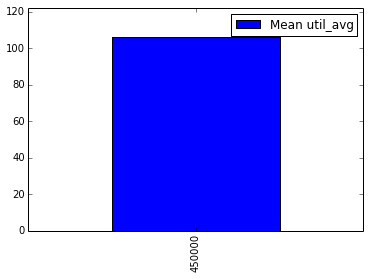

In [9]:
plot_signal_against_freq('util_avg')

### And the same thing for load_avg:

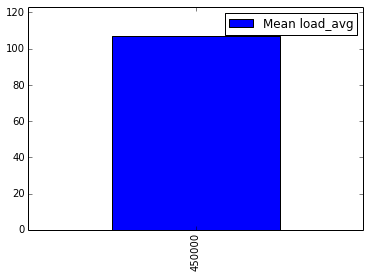

In [10]:
plot_signal_against_freq('load_avg')

## Examine trace from workload execution

Plot task residency and `sched_util` and `sched_load` for the workload task, along with the expected mean value for util_avg. Note that assuming the system was under little load, so that the task was RUNNING whenever it was RUNNABLE, `load_avg` and `util_avg` should be the same. 

Call `examine_experiment` with different experiment indexes to get plots for runs at different frequencies.

In [11]:
signals = ['util_avg', 'load_avg']
def examine_experiment(idx):
    experiment = t.experiments[idx]
    
    [freq] = experiment.conf['cpufreq']['freqs'].values()
    print "Experiment ran at frequency {}".format(freq)
    events = t.te.test_conf["ftrace"]["events"]
    
    print 'Trace plot:'
    plot_trace(t.get_trace(experiment).ftrace)
    
    # Get observed signal
    signal_df = t.get_sched_task_signals(experiment, signals)
    # Get expected average value for util_avg signal
    expected_util_avg_mean = t.get_expected_util_avg(experiment)
    
    # Plot task util_avg signal with expected mean value
    util_avg_mean = pd.Series([expected_util_avg_mean], name='expected_util_avg', index=[signal_df.index[0]])
    df = pd.concat([signal_df, util_avg_mean], axis=1).ffill()
    ILinePlot(df, column=signals + ['expected_util_avg'], drawstyle='steps-post',
             title='Scheduler task signals').view()

In [12]:
for i , f in enumerate(freqs):
    print "Experiment {}:{:10d}Hz".format(i, f)

Experiment 0:    450000Hz


In [13]:
examine_experiment(0)

Experiment ran at frequency 450000
Trace plot:


""
""
